In [2]:
!pip install fuzzywuzzy

You should consider upgrading via the 'c:\users\admin\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [3]:
!pip install surprise

Processing c:\users\admin\appdata\local\pip\cache\wheels\42\41\d3\a56ae864ad22cc6583ec9312be43fbc611c87e53dc49aac953\scikit_surprise-1.1.4-cp39-cp39-win_amd64.whl
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl (15.9 MB)
  Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl (46.2 MB)


You should consider upgrading via the 'c:\users\admin\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz

from surprise import SVD, SVDpp, KNNBasic
from surprise import Dataset
from surprise.model_selection import cross_validate,train_test_split, GridSearchCV
from surprise import NormalPredictor
from surprise import Reader

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk

import warnings
warnings.filterwarnings("ignore")

c:\Users\Admin\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [8]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
df = movies.merge(ratings, how="left", on="movieId")

In [10]:
df.shape

(100854, 6)

In [11]:
df.isnull().sum()

movieId       0
title         0
genres        0
userId       18
rating       18
timestamp    18
dtype: int64

In [12]:
total_missing = df.isnull().sum().sum()
print("Missing Values:",total_missing)
null_percent = total_missing / len(df) * 100
print(f"Percentage of missing values:{null_percent: .2f}% ") #in comparison to the entire dataset

Missing Values: 54
Percentage of missing values: 0.05% 


In [13]:
df.dropna(inplace=True)

In [14]:
df.isnull().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [15]:
df.duplicated().sum()

0

In [16]:
df['title'].nunique()

9719

In [10]:
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09


# Popularity Based Recommendation & Data Insights

In [18]:
#Average ratings of movies
df.groupby('title')['rating'].mean().head()

title
'71 (2014)                                 4.0
'Hellboy': The Seeds of Creation (2004)    4.0
'Round Midnight (1986)                     3.5
'Salem's Lot (2004)                        5.0
'Til There Was You (1997)                  4.0
Name: rating, dtype: float64

In [19]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Gena the Crocodile (1969)                    5.0
True Stories (1986)                          5.0
Cosmic Scrat-tastrophe (2015)                5.0
Love and Pigeons (1985)                      5.0
Red Sorghum (Hong gao liang) (1987)          5.0
Thin Line Between Love and Hate, A (1996)    5.0
Lesson Faust (1994)                          5.0
Eva (2011)                                   5.0
Who Killed Chea Vichea? (2010)               5.0
Siam Sunset (1999)                           5.0
Name: rating, dtype: float64

In [20]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: rating, dtype: int64

In [21]:
#Average Ratings
avg_ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
avg_ratings

,rating
title,
'71 (2014),4.000000
'Hellboy': The Seeds of Creation (2004),4.000000
'Round Midnight (1986),3.500000
'Salem's Lot (2004),5.000000
'Til There Was You (1997),4.000000
...,...
eXistenZ (1999),3.863636
xXx (2002),2.770833
xXx: State of the Union (2005),2.000000


In [22]:
#count of ratings added to average ratings
avg_ratings['Rating Counts'] = pd.DataFrame(df.groupby('title')['rating'].count())
avg_ratings.head()

,rating,Rating Counts
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


Text(0, 0.5, 'Rating')

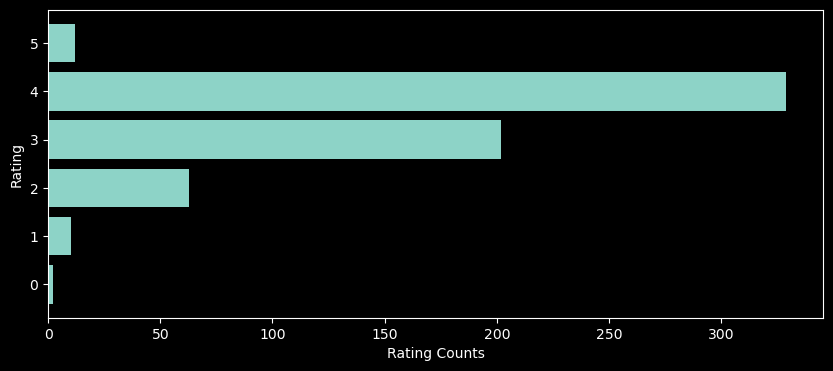

In [23]:
#rating counts with number of movies
plt.figure(figsize=(10,4))
ax=plt.barh(avg_ratings['rating'].round(),avg_ratings['Rating Counts'])
plt.xlabel("Rating Counts")
plt.ylabel("Rating")

In [24]:
avg_ratings = avg_ratings[(avg_ratings['rating']>3) & (avg_ratings['Rating Counts']>100)]
avg_ratings['rating'] = avg_ratings['rating'].round(1)
avg_ratings

,rating,Rating Counts
title,,
2001: A Space Odyssey (1968),3.9,109
Ace Ventura: Pet Detective (1994),3.0,161
Aladdin (1992),3.8,183
Alien (1979),4.0,146
Aliens (1986),4.0,126
...,...,...
Up (2009),4.0,105
"Usual Suspects, The (1995)",4.2,204
WALL·E (2008),4.1,104


In [25]:
avg_ratings = avg_ratings.sort_values(by='rating', ascending=False).head(10)
avg_ratings

,rating,Rating Counts
title,,
"Shawshank Redemption, The (1994)",4.4,317
"Departed, The (2006)",4.3,107
Fight Club (1999),4.3,218
"Godfather, The (1972)",4.3,192
"Godfather: Part II, The (1974)",4.3,129
"Matrix, The (1999)",4.2,278
"Dark Knight, The (2008)",4.2,149
Forrest Gump (1994),4.2,329
Star Wars: Episode V - The Empire Strikes Back (1980),4.2,211


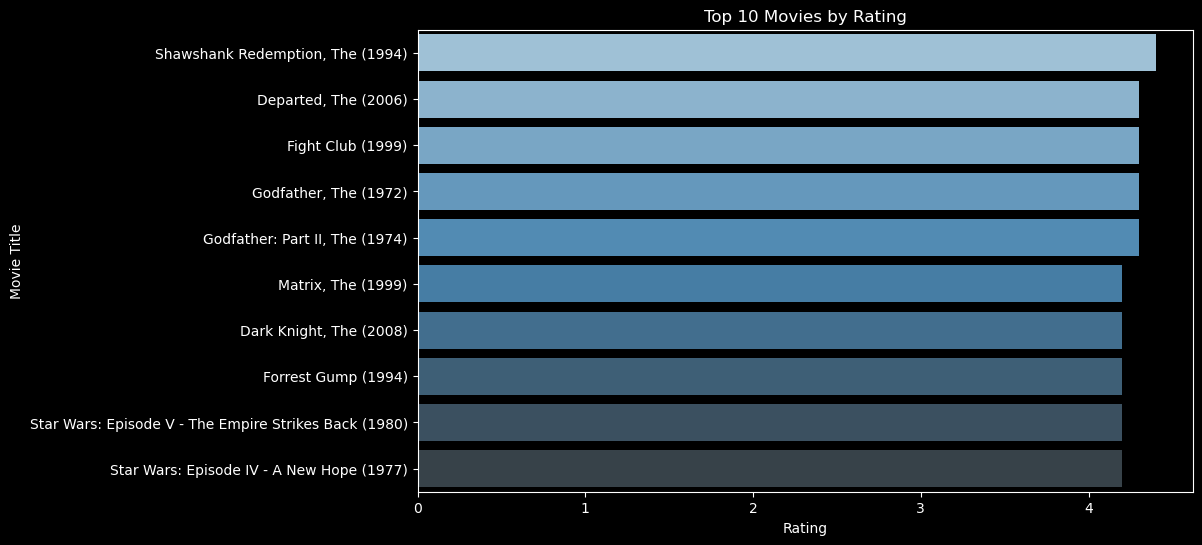

In [26]:
# Sort the DataFrame to get the top 10 movies by rating
avg_ratings = avg_ratings.sort_values(by='rating', ascending=False).head(10)

# Create a horizontal bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='rating', y=avg_ratings.index, data=avg_ratings, palette='Blues_d')

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Movie Title')
plt.title('Top 10 Movies by Rating')

# Show the plot
plt.show()


# Content Based Recommendation

In [11]:
df = df[['userId','movieId','title','genres','rating']]
df.head()

,userId,movieId,title,genres,rating
0,1.0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0
1,5.0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.0
2,7.0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.5
3,15.0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.5
4,17.0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.5


In [28]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Tokenizer function with stemming and stopword removal
def tokenizer(text):
    ps = PorterStemmer()
    tokenized = [ps.stem(word).lower() for word in text.split('|') if word not in stopwords.words('english')]
    return tokenized

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer with the custom tokenizer
tfidf = TfidfVectorizer(analyzer='word', tokenizer=tokenizer)

# Fit and transform the genres column to get TF-IDF vectors
tfidf_matrix = tfidf.fit_transform(movies['genres'])

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix for the TF-IDF vectors
cos_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [31]:
# Create a mapping of movie titles to their index in the DataFrame
movie_indices = pd.Series(movies.index, index=movies['title']).to_dict()

In [90]:
# Function to recommend movies based on content similarity
from fuzzywuzzy import process

# Function to recommend movies based on fuzzy-matched title
def content_based_recommendations(title, movie_indices, cos_sim=cos_sim):
    # Fuzzy match the movie title
    best_match = process.extractOne(title, movie_indices.keys())
    
    # If no good match found, return a message
    if best_match[1] < 70:  # Assuming a threshold of 70 for match confidence
        print(f"No close match found for '{title}'")
        return
    
    # Get the best matching movie title
    matched_title = best_match[0]
    
    # Get the index of the movie by title
    idx = movie_indices[matched_title]
    
    # Get the pairwise similarity scores for all movies with the input movie
    sim_scores = list(enumerate(cos_sim[idx]))
    
    # Sort the movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Remove the movie itself from the list of recommendations
    sim_scores = [score for score in sim_scores if score[0] != idx]
    
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[:10]
    
    # Get the movie indices
    movie_idx = [i[0] for i in sim_scores]
    
    # Return the top 10 most similar movies
    return movies['title'].iloc[movie_idx]


In [91]:

content_based_recommendations('Toy Story (1995)', movie_indices)

1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (Astérix et les Viking...
8219                                         Turbo (2013)
Name: title, dtype: object

In [92]:
content_based_recommendations('Antz (1998)', movie_indices)

0                                        Toy Story (1995)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (Astérix et les Viking...
8219                                         Turbo (2013)
Name: title, dtype: object

In [93]:
content_based_recommendations('Asterix', movie_indices)

5374                              Incredibles, The (2004)
6903                                          Bolt (2008)
8422       Alpha and Omega 3: The Great Wolf Games (2014)
9223                                      Zootopia (2016)
7901    Dragon Ball: The Curse Of The Blood Rubies (Do...
7902    Dragon Ball: Sleeping Princess in Devil's Cast...
7904    Dragon Ball: Mystical Adventure (Doragon bôru:...
7906                                         Brave (2012)
8344    Dragon Ball: The Path to Power (Doragon bôru: ...
9708                                 Incredibles 2 (2018)
Name: title, dtype: object

# Collaborative Filtering Model

In [60]:
import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from sklearn.cluster import KMeans
import joblib


# Step 1: Prepare Data for Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Train the SVD model
trainset = data.build_full_trainset()
svd_model = SVD()
svd_model.fit(trainset)

# Step 2: Apply K-Means Clustering on User Factors
user_factors = svd.pu  # Matrix of user factors

# Define number of clusters for KMeans
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
user_clusters = kmeans.fit_predict(user_factors)

# Step 3: Recommendation Function with Titles
def recommend_movies_with_titles(user_id, svd_model, user_clusters, ratings_df, movies_df, top_n=5):
    # Step 3.1: Identify the cluster of the given user
    user_cluster = user_clusters[user_id]

    # Step 3.2: Get users in the same cluster
    similar_users = [i for i in range(len(user_clusters)) if user_clusters[i] == user_cluster and i != user_id]

    # Step 3.3: Predict ratings for all movies not yet rated by the user
    user_seen_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    all_movie_ids = movies_df['movieId'].unique()
    movies_to_predict = [mid for mid in all_movie_ids if mid not in user_seen_movies]

    # Step 3.4: Predict ratings for unseen movies
    predicted_ratings = []
    for movie_id in movies_to_predict:
        est_rating = svd_model.predict(user_id, movie_id).est
        predicted_ratings.append((movie_id, est_rating))

    # Step 3.5: Sort the movies by predicted rating and select top_n
    top_predictions = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)[:top_n]

    # Step 3.6: Add movie titles to the recommendations
    recommended_movies = []
    for movie_id, rating in top_predictions:
        movie_title = movies_df.loc[movies_df['movieId'] == movie_id, 'title'].values[0]
        recommended_movies.append({'movieId': movie_id, 'title': movie_title})

    return recommended_movies


In [61]:

user_id = 1  # Example user
recommended_movies = recommend_movies_with_titles(user_id, svd, user_clusters, ratings, movies, top_n=5)

print(f"Recommended movies for User {user_id}:")
# Display recommended movies
for movie in recommended_movies:
    print(f"{movie['title']}")


Recommended movies for User 1:
Hoop Dreams (1994)
Shawshank Redemption, The (1994)
Terminator 2: Judgment Day (1991)
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
Rear Window (1954)


In [62]:

# Example Usage
user_id = 2  # Example user
recommended_movies = recommend_movies_with_titles(user_id, svd, user_clusters, ratings, movies, top_n=5)

print(f"Recommended movies for User {user_id}:")
# Display recommended movies
for movie in recommended_movies:
    print(f"{movie['title']}")


Recommended movies for User 2:
Princess Bride, The (1987)
Boondock Saints, The (2000)
Cool Hand Luke (1967)
Rosemary's Baby (1968)
Casablanca (1942)


In [131]:
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split

# Step 1: Train-Test Split for Evaluation
trainset, testset = train_test_split(data, test_size=0.25)

# Step 2: Train the SVD model
svd = SVD()
svd.fit(trainset)

# Step 3: Predict Ratings on the Test Set
predictions = svd.test(testset)

# Step 4: Calculate RMSE and MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)


RMSE: 0.8789
MAE:  0.6736


In [132]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_factors': [50, 100, 150],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.2]
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])


0.8671176520778964
{'n_factors': 150, 'lr_all': 0.01, 'reg_all': 0.1}


In [143]:
def precision_recall_at_k(predictions, k=10, threshold=4.0):
    """Return precision and recall at k metrics for each user"""
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@k: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@k: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    # Average Precision and Recall across all users
    precision_at_k = sum(prec for prec in precisions.values()) / len(precisions)
    recall_at_k = sum(rec for rec in recalls.values()) / len(recalls)

    return precision_at_k, recall_at_k

# Calculate Precision@10 and Recall@10
precision, recall = precision_recall_at_k(predictions, k=10, threshold=4.0)
print(f"Precision@10: {precision}")
print(f"Recall@10: {recall}")


Precision@10: 0.8377426489721578
Recall@10: 0.2872770780077701


In [142]:

top_n = get_top_n(predictions, n=500)  

def coverage(top_n, total_items):
    """Calculate the coverage of recommendations."""
    recommended_items = set(iid for uid in top_n for (iid, _) in top_n[uid])
    return len(recommended_items) / total_items

# Assuming you have a total of `n_items` in your dataset
coverage_score = coverage(top_n, total_items=trainset.n_items)
print(f"Coverage: {coverage_score}")


Coverage: 0.6415676416819013


In [144]:
from itertools import combinations
import numpy as np

def personalization(top_n):
    """Calculate personalization score across users (1 - Jaccard Similarity)."""
    total_pairs = 0
    total_similarity = 0
    for user1, user2 in combinations(top_n.keys(), 2):
        recs1 = set([iid for (iid, _) in top_n[user1]])
        recs2 = set([iid for (iid, _) in top_n[user2]])
        intersection = recs1.intersection(recs2)
        union = recs1.union(recs2)
        if union:
            total_similarity += len(intersection) / len(union)
            total_pairs += 1
    return 1 - (total_similarity / total_pairs if total_pairs != 0 else 0)

personalization_score = personalization(top_n)
print(f"Personalization: {personalization_score}")


Personalization: 0.9894557553498512


# HYBRID MODEL

In [116]:
import random

# Updated Hybrid Recommendation Function with Deduplication
def hybrid_recommendations_v4(user_id, movie_title, svd_model, cos_sim, movies_df, user_clusters, ratings_df, alpha=0.5, top_n=10):
    """
    Hybrid recommendation function with content-based recommendations listed first and deduplication.
    Args:
        user_id (int): The ID of the user for whom recommendations are made.
        movie_title (str): The title of the movie for content-based filtering.
        svd_model: Trained SVD model from Surprise.
        cosine_sim (ndarray): Cosine similarity matrix for content-based filtering.
        movies_df (DataFrame): DataFrame of movies, including their titles.
        user_clusters (ndarray): Clustering results for collaborative filtering.
        ratings_df (DataFrame): DataFrame of user ratings.
        alpha (float): Weight for balancing collaborative and content-based filtering.
        top_n (int): Number of recommendations to return.

    Returns:
        str: Descriptive output of the recommended movies.
    """
    # Step 1: Content-Based Filtering Recommendations
    def content_based_recommendations(movie_title, cos_sim, movies_df, top_n=5):
        if movie_title not in movies_df['title'].values:
            return []

        movie_idx = movies_df[movies_df['title'] == movie_title].index[0]
        sim_scores = list(enumerate(cos_sim[movie_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n + 1]
        movie_indices = [i[0] for i in sim_scores]
        similar_movies = movies_df.iloc[movie_indices][['movieId', 'title']]
        similar_movies['type'] = 'content-based'
        return similar_movies.to_dict(orient='records')

    # Step 2: Collaborative Filtering Recommendations
    def collaborative_recommendations(user_id, svd_model, user_clusters, ratings_df, movies_df, top_n=5):
        user_cluster = user_clusters[user_id]
        similar_users = [i for i in range(len(user_clusters)) if user_clusters[i] == user_cluster and i != user_id]
        user_seen_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
        all_movie_ids = movies_df['movieId'].unique()
        movies_to_predict = [mid for mid in all_movie_ids if mid not in user_seen_movies]

        predicted_ratings = []
        for movie_id in movies_to_predict:
            est_rating = svd_model.predict(user_id, movie_id).est
            predicted_ratings.append((movie_id, est_rating))

        top_predictions = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)[:top_n]

        recommended_movies = []
        for movie_id, rating in top_predictions:
            movie_title = movies_df.loc[movies_df['movieId'] == movie_id, 'title'].values[0]
            recommended_movies.append({'movieId': movie_id, 'title': movie_title, 'predicted_rating': rating, 'type': 'collaborative'})

        return recommended_movies

    # Step 3: Generate Recommendations
    # Content-Based Recommendations First
    content_recs = content_based_recommendations(movie_title, cos_sim, movies_df, top_n=int(top_n * (1 - alpha)))

    # Collaborative Recommendations Second
    collab_recs = collaborative_recommendations(user_id, svd_model, user_clusters, ratings_df, movies_df, top_n=int(top_n * alpha))

    # Step 4: Combine and Deduplicate Recommendations
    # Use a dictionary to ensure there are no duplicates
    final_recommendations_dict = {}

    # Add content-based recommendations first
    for rec in content_recs:
        final_recommendations_dict[rec['movieId']] = rec

    # Add collaborative recommendations, only if not already present
    for rec in collab_recs:
        if rec['movieId'] not in final_recommendations_dict:
            final_recommendations_dict[rec['movieId']] = rec

    # Step 5: Convert dictionary to a list and limit to top_n
    final_recommendations = list(final_recommendations_dict.values())[:top_n]

    # Step 6: Construct the Descriptive Output
    output = f"User {user_id}: Based on your interest in '{movie_title}', you likely to enjoy:\n"
    for rec in final_recommendations:
        output += f"- {rec['title']}\n"

    return output


In [122]:

# Example Usage
user_id = 5  # Replace with the desired user ID
movie_title = "The Matrix"  # Replace with the desired movie title
recommended_output = hybrid_recommendations_v4(user_id, movie_title, svd_model, cos_sim, movies, user_clusters, ratings, alpha=0.5, top_n=10)
print(recommended_output)


User 5: Based on your interest in 'The Matrix', you likely to enjoy:
- Lawrence of Arabia (1962)
- Amadeus (1984)
- Full Metal Jacket (1987)
- Clockwork Orange, A (1971)
- Casablanca (1942)



In [120]:

# Example Usage
user_id = 3  # Replace with the desired user ID
movie_title = "Toy Story (1995)"  # Replace with the desired movie title
recommended_output = hybrid_recommendations_v4(user_id, movie_title, svd_model, cos_sim, movies, user_clusters, ratings, alpha=0.5, top_n=10)
print(recommended_output)


User 3: Based on your interest in 'Toy Story (1995)', you likely to enjoy:
- Antz (1998)
- Toy Story 2 (1999)
- Adventures of Rocky and Bullwinkle, The (2000)
- Emperor's New Groove, The (2000)
- Monsters, Inc. (2001)
- Streetcar Named Desire, A (1951)
- Departed, The (2006)
- Howl's Moving Castle (Hauru no ugoku shiro) (2004)
- Do the Right Thing (1989)
- City of God (Cidade de Deus) (2002)



In [125]:

# Example Usage
user_id = 10 
movie_title = "- Singin' in the Rain (1952)"  

# Print recommendations
recommended_output = hybrid_recommendations_v4(user_id, movie_title, svd_model, cos_sim, movies, user_clusters, ratings, top_n=10)
print(recommended_output)


User 10: Based on your interest in '- Singin' in the Rain (1952)', you likely to enjoy:
- Wizard of Oz, The (1939)
- Harry Potter and the Deathly Hallows: Part 1 (2010)
- Streetcar Named Desire, A (1951)
- Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
- North by Northwest (1959)



In [110]:

# Example Usage
user_id = 3  # Replace with the desired user ID
movie_title = "Toy Story"  # Replace with the desired movie title

# Print recommendations
recommended_output = hybrid_recommendations(user_id, movie_title, svd_model, cos_sim, movies, user_clusters, ratings, top_n=10)
print(recommended_output)


User 3: Based on your interest in 'Toy Story', you likely to enjoy:
- Streetcar Named Desire, A (1951)
- Departed, The (2006)
- Howl's Moving Castle (Hauru no ugoku shiro) (2004)
- Do the Right Thing (1989)
- City of God (Cidade de Deus) (2002)
- Into the Wild (2007)
- 12 Angry Men (1957)
- Silence of the Lambs, The (1991)
- Misery (1990)
- Grave of the Fireflies (Hotaru no haka) (1988)



# Hybrid Model

In [126]:
from fuzzywuzzy import process

def hybrid_recommendations(user_id, title, svd_model, movie_indices, cos_sim, movies, ratings, top_n=10):
    """
    Generate hybrid recommendations by combining collaborative filtering (SVD) and content-based filtering with fuzzy matching.
    """
    # Step 1: Fuzzy match the movie title
    best_match = process.extractOne(title, movie_indices.keys())

    # If no good match found, return a message
    if best_match[1] < 70:  # Assuming a threshold of 70 for fuzzy match confidence
        print(f"No close match found for '{title}'")
        return

    # Get the best matching movie title and its index
    matched_title = best_match[0]
    idx = movie_indices[matched_title]

    # Step 2: Get content-based recommendations (similar movies based on genres)
    sim_scores = list(enumerate(cos_sim[idx]))

    # Sort the movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Remove the input movie itself from the list of recommendations
    sim_scores = [score for score in sim_scores if score[0] != idx]

    # Get the indices of the top N similar movies
    movie_indices_content = [i[0] for i in sim_scores[:top_n]]

    # Step 3: Collaborative filtering prediction for unrated movies
    user_rated_movies = ratings[ratings['userId'] == user_id]['movieId'].values
    unrated_movie_ids = [movies['movieId'].iloc[i] for i in movie_indices_content if movies['movieId'].iloc[i] not in user_rated_movies]

    collaborative_scores = {}
    for movie_id in unrated_movie_ids:
        collaborative_scores[movie_id] = svd_model.predict(user_id, movie_id).est

    # Step 4: Combine content-based similarity and collaborative filtering scores
    hybrid_scores = {}
    for idx in movie_indices_content:
        movie_id = movies['movieId'].iloc[idx]
        content_score = cos_sim[idx, movie_indices[matched_title]]
        collaborative_score = collaborative_scores.get(movie_id, 0)
        # Combine scores (adjust weights as needed, 50% each here)
        hybrid_scores[movie_id] = (0.5 * content_score) + (0.5 * collaborative_score)

    # Step 5: Sort the movies by hybrid score and return the top N recommendations
    top_movie_ids = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    recommended_movies = movies[movies['movieId'].isin([movie_id for movie_id, score in top_movie_ids])]

    return recommended_movies



In [128]:

# Example usage:
recommended_movies = hybrid_recommendations(1, "Toy Story (1995)", svd_model, movie_indices, cos_sim, movies, ratings, top_n=5)
print(recommended_movies[['movieId', 'title']])


      movieId                                           title
1706     2294                                     Antz (1998)
2355     3114                              Toy Story 2 (1999)
2809     3754  Adventures of Rocky and Bullwinkle, The (2000)
3000     4016                Emperor's New Groove, The (2000)
3568     4886                           Monsters, Inc. (2001)


In [130]:
user_id = 3  
movie_title = "Toy Story"  
recommended_movies = hybrid_recommendations(user_id, movie_title, svd_model, movie_indices, cos_sim, movies, ratings, top_n=10)
print(recommended_movies[['movieId', 'title']])


      movieId                                              title
1706     2294                                        Antz (1998)
2355     3114                                 Toy Story 2 (1999)
2809     3754     Adventures of Rocky and Bullwinkle, The (2000)
3000     4016                   Emperor's New Groove, The (2000)
3568     4886                              Monsters, Inc. (2001)
6194    45074                                   Wild, The (2006)
6486    53121                             Shrek the Third (2007)
6948    65577                     Tale of Despereaux, The (2008)
7760    91355  Asterix and the Vikings (Astérix et les Viking...
8219   103755                                       Turbo (2013)


In [146]:
# Make predictions for the test set
predictions = svd_model.test(testset)

# Calculate RMSE and MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)


RMSE: 0.6392
MAE:  0.4955


In [147]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=4.0):
    """Return precision and recall at k metrics for each user"""
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@k: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@k: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    # Average precision and recall across all users
    precision_at_k = sum(prec for prec in precisions.values()) / len(precisions)
    recall_at_k = sum(rec for rec in recalls.values()) / len(recalls)

    return precision_at_k, recall_at_k

# Example usage:
precision, recall = precision_recall_at_k(predictions, k=10, threshold=4.0)
print(f"Precision@10: {precision}")
print(f"Recall@10: {recall}")


Precision@10: 0.9677153265677851
Recall@10: 0.3756088229752967


In [154]:

def coverage(top_n_recommendations, total_items):
    """Calculate coverage of the recommendations."""
    recommended_items = set(iid for uid in top_n_recommendations for (iid, _) in top_n_recommendations[uid])
    return len(recommended_items) / total_items

# Assuming you have a list of top-N recommendations for each user
top_n_recommendations = get_top_n(predictions, n=20000)
coverage_score = coverage(top_n_recommendations, total_items=len(movies))
print(f"Coverage: {coverage_score}")


Coverage: 0.5808868815438308


In [158]:
from itertools import combinations

def personalization(top_n_recommendations):
    total_similarity = 0.0
    total_pairs = 0

    # Compare each pair of users
    for user1, user2 in combinations(top_n_recommendations.keys(), 2):
        recs1 = set(iid for (iid, _) in top_n_recommendations[user1])
        recs2 = set(iid for (iid, _) in top_n_recommendations[user2])

        intersection = recs1.intersection(recs2)
        union = recs1.union(recs2)

        if union:
            total_similarity += len(intersection) / len(union)
            total_pairs += 1

    return 1 - (total_similarity / total_pairs if total_pairs != 0 else 0)

# Example usage:
personalization_score = personalization(top_n_recommendations)
print(f"Personalization: {personalization_score}")


Personalization: 0.9894570097278226


# SAVING MODELS

In [160]:
import joblib

# Save the trained SVD model to a file
joblib.dump(svd_model, 'svd_model2.pkl')

# Save the cosine similarity matrix (if you're using content-based filtering)
joblib.dump(cos_sim, 'cosine_sim1.pkl')

# Save the movies DataFrame (if needed)
joblib.dump(movies, 'movies1.pkl')


['movies1.pkl']